# Modélisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import html5lib
from bs4 import BeautifulSoup
import re
from string import punctuation
import nltk.corpus
from ast import literal_eval


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# spacy for lemmatization
import spacy
import sklearn.metrics as metrics

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
#
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_feather('cleaned_data_stackoverflow_questions.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43801 entries, 0 to 43800
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title_cleaned    43801 non-null  object
 1   Body_cleaned     43801 non-null  object
 2   Tags_cleaned     43801 non-null  object
 3   Title_tokenized  43801 non-null  object
 4   Body_tokenized   43801 non-null  object
 5   Tags_tokenized   43801 non-null  object
 6   Tags_list        43801 non-null  object
 7   number_of_tags   43801 non-null  int64 
 8   Id               43801 non-null  int64 
 9   Score            43801 non-null  int64 
 10  ViewCount        43801 non-null  int64 
 11  AnswerCount      43801 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 4.0+ MB


In [4]:
df.head()

,Title_cleaned,Body_cleaned,Tags_cleaned,Title_tokenized,Body_tokenized,Tags_tokenized,Tags_list,number_of_tags,Id,Score,ViewCount,AnswerCount
0,when porting java code to objc how best to rep...,i am working on porting a java codebase to coc...,java objective-c cocoa macos porting,"[porting, java, code, objc, best, represent, c...","[working, porting, java, codebase, cocoaobject...","[java, objective-c, cocoa, macos, porting]","[java, objective-c, macos]",3,1117384,8,1346,6
1,is there a way for hiding some enum values for...,i have enum lets say for example and have two ...,c# .net winforms windows-forms-designer prope...,"[way, hiding, enum, values, specific, property...","[enum, lets, say, example, two, classes, prope...","[c#, .net, winforms, windows-forms-designer, p...","[c#, .net]",2,59024032,8,2172,1
2,fixing words with spaces using a dictionary lo...,i have extracted the list of sentences from a ...,python python-2.7 dictionary nltk text-segmen...,"[fixing, words, spaces, using, dictionary, loo...","[extracted, list, sentences, document, preproc...","[python, python-2.7, dictionary, nltk, text-se...",[python],1,19675106,19,6507,7
3,how to split a string at line breaks in python,i want to copy some tabular data from excel in...,python arrays list clipboard pywin32,"[split, string, line, breaks, python]","[want, copy, tabular, data, excel, python, arr...","[python, arrays, list, clipboard, pywin32]","[python, arrays]",2,21205074,6,7848,5
4,how do you express binary literals in python,how do you express an integer as a binary numb...,python syntax binary integer literals,"[express, binary, literals, python]","[express, integer, binary, number, python, lit...","[python, syntax, binary, integer, literals]",[python],1,1476,394,317942,8


In [5]:
# concaténation de title + body
df['text'] = [list(x.tolist()+ y.tolist()) for x, y in zip(df['Title_tokenized'], df['Body_tokenized'])]

In [6]:

df['text_sentences'] = df['Title_cleaned']+' '+ df['Body_cleaned']

In [7]:
df.set_index('Id', inplace=True)
X = df["text"]
y = df["Tags_list"]

In [8]:
df['Body_cleaned'][21205074]

"i want to copy some tabular data from excel into a python array that is user willselect a range in an excel table press copy ctrl+c so that the range will be copied to clipboard then i will get this clipboard data into a python array list i use to get clipboard data into an array i copy the following range from excel when i use the function above i get a string like how to split this string into a list so that the list will look like i use method but it doesn't give me what i want "

 ## Encodage TF-IDF

Nos données ayant déjà été cleanées et tokenisées dans le Notebook exploration,  nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn. Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). Dans cette partie, nous allons éliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).

la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

Pour préparer nos targets (pour les modèles supervisés), nous allons utiliser MultiLabelBinarizer de Scikit-Learn puisque nos Tags sont multiples.

In [9]:
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
data_vectorized = vectorizer.transform(X)
print("Shape of X for Doc: {}".format(data_vectorized.shape))

Shape of X for Doc: (43801, 1573)


In [10]:


# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of y: (43801, 50)


# Unsupervised approach  

## LDA

Modèle LDA:
LDA, ou Latent Derelicht Analysis est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité :  
P(word|topics) et  P(topics|document). Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

Un modèle avec une Log Likelihood plus élevée et une perplexité plus faible (exp(-1. * log-vraisemblance par mot)) est considéré comme bon. Vérifions notre modèle.

### gridsearch best LDA model

Le paramètre de réglage le plus important pour les modèles LDA est n_components (nombre de sujets). De plus, je vais également rechercher learning_decay (qui contrôle le taux d'apprentissage).

In [11]:
# Define Search Param
search_params = {'n_components': [10, 20, 30, 40, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 20, 30, 40, 50]})

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -347281.37499273295
Model Perplexity:  2161.115466061239


Résultats : 
  >  Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
  
  >  Best Log Likelihood Score:  -347505.197561824
  
  >  Model Perplexity:  2146.8385382147712

In [21]:
best_lda = LatentDirichletAllocation(n_components= 10, learning_decay= 0.9)
best_lda_model = best_lda.fit_transform(data_vectorized)

In [22]:
# Log Likelihood Score
print(" Log Likelihood Score: ", best_lda.score(data_vectorized))

# Perplexity
print("Model Perplexity: ", best_lda.perplexity(data_vectorized))

 Log Likelihood Score:  -1613031.756393458
Model Perplexity:  2171.8632838935173


### Visualisation 

In [25]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda, data_vectorized, vectorizer ,mds='mmds')
panel

C:\Users\Twins\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.055024  0.090743       1        1  16.354407
7     -0.013310  0.010184       2        1  15.206897
3      0.066434 -0.002531       3        1  14.591512
9     -0.055318 -0.091301       4        1  12.638977
1     -0.113385  0.080187       5        1   9.224158
6     -0.061823  0.131319       6        1   8.615628
5      0.142164  0.036667       7        1   7.588159
8     -0.110592  0.002686       8        1   6.229641
2      0.094916 -0.095718       9        1   4.958706
0     -0.004111 -0.162237      10        1   4.591916, topic_info=        Term         Freq        Total Category  logprob  loglift
531     file  1080.000000  1080.000000  Default  30.0000  30.0000
668    image   553.000000   553.000000  Default  29.0000  29.0000
463    error  1001.000000  1001.000000  Default  28.0000  28.0000
863   memory   356.000000   356.000000  Default  27.0000  27.0000
1344  string   522.000000   522.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1492   using    74.380525  1418.161281  Topic10  -4.8645   0.1330
781     like    63.751212  1232.773998  Topic10  -5.0187   0.1188
785     line    49.200339   411.190314  Topic10  -5.2778   0.9577
228     code    52.877925  1309.640057  Topic10  -5.2057  -0.1286
1518    want    50.103283   938.388178  Topic10  -5.2596   0.1508

[567 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
14        1  0.062486  activity
14        2  0.031243  activity
14        3  0.023432  activity
14        5  0.179646  activity
14        6  0.039054  activity
...     ...       ...       ...
1568      6  0.022573       xml
1568      7  0.030097       xml
1568      8  0.045145       xml
1568      9  0.507886       xml
1568     10  0.063956       xml

[3303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 4, 10, 2, 7, 6, 9, 3, 1])

Pour attribuer des Tags à chaque question sur ces modèles non-supervisés, nous allons créer une matrice document/ topic et Topic/Tags 

### The dominant topic in each document

In [129]:
# Create Document - Topic Matrix
lda_output = best_lda.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics_ = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics_

# Document/topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,3
Doc1,0.020000,0.020000,0.020000,0.550000,0.020000,0.020000,0.020000,0.020000,0.320000,0.020000,3
Doc2,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.840000,9
Doc3,0.240000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.600000,9
Doc4,0.020000,0.020000,0.050000,0.020000,0.760000,0.020000,0.020000,0.020000,0.020000,0.020000,4
Doc5,0.190000,0.010000,0.010000,0.410000,0.010000,0.300000,0.010000,0.010000,0.010000,0.010000,3
Doc6,0.030000,0.730000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,1
Doc7,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,3
Doc8,0.020000,0.020000,0.020000,0.020000,0.800000,0.020000,0.020000,0.020000,0.020000,0.020000,4
Doc9,0.010000,0.010000,0.010000,0.010000,0.430000,0.010000,0.010000,0.470000,0.010000,0.010000,7


In [22]:
df_document_topic.shape

(43801, 11)

###  the Topic’s keywords

Les pondérations de chaque mot-clé dans chaque rubrique sont contenues dans lda_model.components_ sous la forme d'un tableau 2d.

Les noms des mots-clés eux-mêmes peuvent être obtenus à partir de l'objet vectoriseur en utilisant get_feature_names().

In [130]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

#Topics/mots

,ability,able,accept,accepted,access,accessing,accomplish,according,account,achieve,...,written,wrong,wrote,xaml,xcode,xml,years,yes,yet,zero
Topic0,0.187789,13.122057,0.237297,0.295466,9.161383,1.559055,3.273609,2.484905,0.176158,6.212469,...,11.098663,8.534015,3.796455,0.100001,0.100011,13.585182,0.152056,2.374894,1.390606,2.082466
Topic1,4.210199,46.721321,5.580295,3.284917,11.325197,2.033629,9.118875,8.780859,3.901764,29.785767,...,8.357236,32.011286,4.110905,6.981347,61.381060,17.804823,2.315174,6.449932,11.035042,4.294768
Topic2,1.954550,18.111315,1.730248,2.088504,4.719829,0.100007,2.950170,3.552470,0.305256,6.271507,...,14.701894,9.241084,2.585249,0.647541,1.611003,109.196504,3.729697,1.217339,2.356381,0.486967
Topic3,6.785528,48.073106,11.924502,11.014814,53.406116,16.383263,7.985995,22.807293,2.390206,17.272525,...,39.648330,34.611651,18.688740,0.100018,3.715218,9.116580,14.665800,18.416851,29.956137,10.506495
Topic4,5.061925,77.498988,4.749017,4.997427,59.232909,5.617755,4.374771,15.641593,11.350041,11.203698,...,26.665100,54.278366,11.895337,0.990431,129.149839,13.589291,12.004918,12.328925,22.659273,1.573005
Topic5,0.331615,18.539376,5.540965,3.769782,19.654346,5.982384,1.880629,12.821731,1.231120,5.252090,...,8.062740,49.952132,7.811101,0.292614,17.087491,7.816089,0.100004,5.589314,9.983746,6.886955
Topic6,4.122939,31.220659,2.995161,1.243639,13.562962,0.897402,7.989773,6.294554,5.013399,22.253365,...,3.368315,22.406383,2.730259,1.413637,2.357631,5.815928,1.678160,6.144428,9.116189,0.771668
Topic7,7.713780,70.799847,19.435256,5.106800,124.708381,16.750467,8.372124,17.795120,47.485969,19.485354,...,21.584893,52.736380,9.409487,0.100086,0.863696,33.272223,3.450853,9.503781,16.293497,3.319484
Topic8,2.578474,22.813262,0.308924,1.679043,12.916489,1.682354,5.788458,7.208292,1.073702,12.358760,...,4.267726,15.687942,2.574434,52.322746,1.355959,11.103768,0.511276,4.891090,7.094425,2.660200
Topic9,3.826464,47.561567,5.873827,2.552300,29.530551,5.012841,15.736723,13.901605,7.848903,29.619311,...,13.117926,31.998884,13.663129,0.100000,0.100009,18.225467,8.520446,10.261564,17.512945,25.540838


### Top N keyword for each topic 

In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords_ = pd.DataFrame(topic_keywords)
df_topic_keywords_.columns = ['Word '+str(i) for i in range(df_topic_keywords_.shape[1])]
df_topic_keywords_.index = ['Topic '+str(i) for i in range(df_topic_keywords_.shape[0])]
df_topic_keywords_

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,image,xml,file,element,images,css,like,using,html,want,node,upload,tag,jquery,text,path,tree,files,rails,form
Topic 1,view,button,ios,image,text,app,code,color,using,want,screen,like,bar,set,change,android,user,background,click,window
Topic 2,table,sql,query,column,database,data,date,like,columns,mysql,rows,using,want,dataframe,values,row,get,way,would,pandas
Topic 3,memory,code,would,use,using,like,one,python,time,performance,data,way,two,array,algorithm,know,difference,java,question,size
Topic 4,class,type,function,string,object,array,method,code,like,value,use,error,using,following,way,would,get,want,variable,example
Topic 5,project,file,error,studio,build,files,windows,visual,using,version,code,use,library,android,run,application,get,like,eclipse,net
Topic 6,server,error,app,using,get,application,user,file,client,connection,request,run,running,code,use,api,service,trying,web,following
Topic 7,test,tests,thread,unit,code,method,exception,event,mock,error,run,component,using,call,testing,function,like,called,use,way
Topic 8,file,html,page,javascript,pdf,chrome,video,using,browser,files,url,image,firefox,code,stream,ie,audio,like,data,download
Topic 9,spring,model,mvc,aspnet,controller,entity,using,data,service,class,use,like,web,method,application,hibernate,request,get,database,json


### prediction for each doc

 pondérer les lignes de la matrice topic-mots par les probabilités de la matrice document-topic. On pourra ensuite faire la somme des probas pour tous les topics et garder ensuite les n-termes les plus probables

In [26]:
# pondérer les lignes de la matrice topic-mots par les probabilités de la matrice document-topic
df_document_words =np.dot(df_document_topic.iloc[:,:-1].values,  df_topic_keywords.values)

In [28]:
df_document_words = pd.DataFrame(df_document_words)
df_document_words.columns = vectorizer.get_feature_names_out()
df_document_words.index = X.index
df_document_words

,ability,able,accept,accepted,access,accessing,accomplish,according,account,achieve,...,written,wrong,wrote,xaml,xcode,xml,years,yes,yet,zero
Id,,,,,,,,,,,,,,,,,,,,,
1117384,4.333553,40.370441,3.025325,3.353060,24.116245,3.392378,4.905348,10.053808,2.413113,11.513178,...,19.730466,35.791573,10.308877,3.557920,56.113652,14.060966,5.659789,7.370934,14.771206,2.972628
59024032,4.777976,50.755303,10.497820,7.610444,32.036700,7.645001,11.075620,18.024190,4.603387,25.904791,...,13.156806,44.544740,9.279924,21.294667,28.862295,24.574538,2.990319,11.828197,16.347834,9.175504
19675106,3.825997,44.261125,13.482308,9.475107,41.413148,11.225638,9.417891,21.711598,3.801546,17.177958,...,15.939312,46.248954,11.600272,7.019656,9.867426,25.242105,3.112823,12.091460,16.423600,11.799752
21205074,3.788307,43.817565,13.332128,9.368345,40.990602,11.102404,9.319495,21.473966,3.774887,17.007425,...,15.781728,45.760908,11.477651,6.949428,9.800194,24.992695,3.086357,11.962827,16.254385,11.670029
1476,5.147239,50.463756,3.216190,3.610455,26.687628,3.168661,4.687425,13.631499,2.439722,11.689657,...,23.889445,37.459332,11.368789,5.506275,100.516125,21.186057,9.761682,10.774358,16.729728,2.057899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572059,3.863686,44.704685,13.632489,9.581868,41.835694,11.348873,9.516287,21.949230,3.828205,17.348490,...,16.096895,46.737001,11.722894,7.089884,9.934658,25.491514,3.139290,12.220092,16.592815,11.929476
41050942,5.491013,53.781251,3.375828,3.835635,28.240090,3.328267,4.947529,14.520257,2.503945,12.351633,...,25.515834,39.892852,12.134255,5.837078,108.009244,22.463631,10.448885,11.493641,17.834800,2.127674
3944122,5.837308,56.989234,5.748271,4.574161,17.377259,2.249877,12.745858,11.878755,5.522729,36.547177,...,8.635177,39.691033,5.556094,39.814203,53.644655,22.363255,2.687285,10.794981,15.346733,5.011650


In [29]:
N_topic = 30
df_document_keywords = pd.DataFrame(df_document_words.apply(lambda x: x.nlargest(N_topic).index.tolist(), axis=1).tolist(), index= df_document_words.index)


In [30]:
df_document_keywords.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Id,,,,,,,,,,,,,,,,,,,,,
1117384,test,error,file,code,project,using,use,run,like,get,...,visual,app,following,would,ve,want,method,trying,tried,one
59024032,class,code,like,type,function,using,object,string,use,want,...,work,image,ios,example,button,problem,set,know,text,need
19675106,class,type,function,string,object,code,array,like,method,use,...,java,return,convert,one,list,something,constructor,objects,parameter,json
21205074,class,type,function,string,object,code,array,like,method,use,...,java,return,convert,one,list,something,constructor,objects,parameter,json
1476,project,file,error,studio,using,build,files,code,windows,use,...,app,net,ve,eclipse,package,module,tried,find,following,installed


In [31]:
df_document_keywords['topics'] = df_document_keywords.stack().groupby(level=list(range(df_document_keywords.index.nlevels))).agg(list)

In [32]:
df_document_keywords.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,topics
Id,,,,,,,,,,,,,,,,,,,,,
1117384,test,error,file,code,project,using,use,run,like,get,...,app,following,would,ve,want,method,trying,tried,one,"[test, error, file, code, project, using, use,..."
59024032,class,code,like,type,function,using,object,string,use,want,...,image,ios,example,button,problem,set,know,text,need,"[class, code, like, type, function, using, obj..."
19675106,class,type,function,string,object,code,array,like,method,use,...,return,convert,one,list,something,constructor,objects,parameter,json,"[class, type, function, string, object, code, ..."
21205074,class,type,function,string,object,code,array,like,method,use,...,return,convert,one,list,something,constructor,objects,parameter,json,"[class, type, function, string, object, code, ..."
1476,project,file,error,studio,using,build,files,code,windows,use,...,net,ve,eclipse,package,module,tried,find,following,installed,"[project, file, error, studio, using, build, f..."


### Evaluation



A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

In [46]:
transpose = df_document_topic.T

In [47]:
transpose.shape

(11, 43801)

In [48]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(transpose.to_numpy(), y_binarized)
topic_tag.shape

(11, 50)

In [49]:
topic_tag = pd.DataFrame(topic_tag)
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,132.73,37.80,47.46,103.95,32.88,29.61,56.52,34.50,40.81,245.14,...,26.87,42.64,34.61,26.65,18.70,17.66,31.59,25.46,27.78,136.65
1,307.09,54.72,21.44,915.84,71.37,26.78,100.69,47.05,55.24,637.80,...,20.59,27.09,382.61,47.13,21.75,37.60,87.29,367.08,264.56,58.11
2,243.74,23.50,53.48,113.05,19.70,100.61,91.70,39.87,44.12,499.38,...,464.20,82.23,39.01,20.77,25.41,19.62,28.57,24.43,22.33,45.82
3,433.97,20.89,416.81,185.02,13.95,217.44,68.57,31.01,586.93,667.77,...,48.78,123.94,51.96,16.22,49.69,43.23,125.57,44.12,45.01,37.93
4,540.01,25.89,45.88,189.95,36.86,318.33,94.14,41.72,314.91,1041.49,...,46.25,293.99,166.27,84.26,71.66,52.67,54.52,65.37,68.18,73.03
5,533.13,13.15,13.53,632.86,85.61,20.19,138.60,66.62,335.78,816.34,...,45.17,24.51,122.01,147.37,106.05,380.27,352.72,73.87,303.44,59.59
6,344.33,79.87,17.01,527.33,64.85,20.54,252.05,90.05,91.45,619.28,...,127.37,20.40,98.28,33.08,31.42,41.20,175.78,22.42,89.55,33.99
7,321.31,54.33,15.21,217.25,104.56,22.16,73.65,41.05,84.12,586.53,...,32.07,20.97,50.85,108.90,403.28,41.58,53.90,60.77,48.35,16.17
8,161.68,158.33,16.96,179.83,24.17,28.86,107.78,46.49,49.15,297.07,...,19.40,34.67,61.55,25.33,18.43,21.62,55.68,19.06,32.09,41.23
9,333.28,71.65,13.19,102.87,50.70,23.55,329.56,373.10,30.65,842.93,...,54.94,15.70,32.36,43.14,77.61,28.76,25.00,41.81,27.79,48.94


Nous obtenons donc une matrice dont les lignes représentent les Topics créés et les colonnes les Tags associés et leurs distribution. Nous allons donc créer nos prédictions en prenant les  premiers tags associés aux topics de chaque document :

In [52]:
df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)
tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

In [53]:
tags_num

[[20, 25, 29],
 [0, 9],
 [32],
 [5, 32],
 [32],
 [10, 15, 45],
 [16, 18, 19],
 [9, 47],
 [46],
 [13, 27, 31],
 [10],
 [18, 48],
 [13, 39, 40],
 [2],
 [10, 15],
 [30],
 [6, 9, 13],
 [3],
 [1, 21],
 [0, 9, 26],
 [20, 41, 49],
 [20, 46],
 [21, 44],
 [18],
 [10, 11],
 [9, 10, 46],
 [9, 10],
 [0, 9],
 [31],
 [13, 39],
 [10, 32, 44],
 [32],
 [3],
 [3],
 [0, 9],
 [10, 15],
 [0],
 [0, 20],
 [16, 21, 22, 39],
 [32],
 [0, 46],
 [0, 6, 9],
 [0, 9],
 [8, 17],
 [0, 9, 10, 46],
 [14, 32],
 [13, 27],
 [12, 16, 21, 22],
 [6, 9, 49],
 [0, 9],
 [18],
 [0, 30],
 [13, 30],
 [2, 32],
 [6, 28, 45],
 [20],
 [24],
 [45],
 [9, 49],
 [21, 43],
 [39],
 [32, 33],
 [0, 9],
 [0, 9, 49],
 [0, 9, 30, 41],
 [10],
 [32, 46],
 [9],
 [6],
 [32],
 [18, 29],
 [0, 9],
 [13],
 [6, 9],
 [32],
 [6, 9],
 [32],
 [0, 9, 24],
 [20, 49],
 [9, 27, 45],
 [39],
 [24, 32],
 [10, 46],
 [0, 24],
 [0, 6],
 [1, 20, 22],
 [36],
 [47],
 [24, 31],
 [18, 42, 48],
 [31],
 [0, 9],
 [32, 33],
 [0, 5, 9, 41],
 [21],
 [31],
 [3, 20],
 [10, 20],
 [9

In [54]:
df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true_"] = tags_num
y_results.head()

,y_true,number_of_tags,best_topic,y_pred,y_intersection,len_pred,accuracy_local,y_true_
Id,,,,,,,,
1117384,"[java, objective-c, macos]",3,7,"[test, error, file, code, project, using, use,...",[],0,0.0,"[20, 25, 29]"
59024032,"[c#, .net]",2,4,"[class, code, like, type, function, using, obj...",[],0,0.0,"[0, 9]"
19675106,[python],1,4,"[class, type, function, string, object, code, ...",[],0,0.0,[32]
21205074,"[python, arrays]",2,4,"[class, type, function, string, object, code, ...",[],0,0.0,"[5, 32]"
1476,[python],1,5,"[project, file, error, studio, using, build, f...",[python],1,1.0,[32]


In [55]:
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.number_of_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic].sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred_"] = list_tag
y_results.head()

,y_true,number_of_tags,best_topic,y_pred,y_intersection,len_pred,accuracy_local,y_true_,y_pred_
Id,,,,,,,,,
1117384,"[java, objective-c, macos]",3,7,"[test, error, file, code, project, using, use,...",[],0,0.0,"[20, 25, 29]","[9, 21, 20]"
59024032,"[c#, .net]",2,4,"[class, code, like, type, function, using, obj...",[],0,0.0,"[0, 9]","[10, 9]"
19675106,[python],1,4,"[class, type, function, string, object, code, ...",[],0,0.0,[32],[10]
21205074,"[python, arrays]",2,4,"[class, type, function, string, object, code, ...",[],0,0.0,"[5, 32]","[10, 9]"
1476,[python],1,5,"[project, file, error, studio, using, build, f...",[python],1,1.0,[32],[20]


Nous allons tester plusieurs métriques sur ce modèle LDA :

- Accuracy score :
- F1 score :
- Jaccard similarity score :
- Recall :
- Precision :

In [56]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred_.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true_.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [83]:
lda_y_pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [84]:
 lda_y_true[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:


def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [58]:


df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Accuracy,0.078286
F1,0.293594
Jaccard,0.080826
Recall,0.215514
Precision,0.157330


# Supervised approaches

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [12]:
# Initialize the "CountVectorizer" TFIDF for Doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)


In [13]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (30660, 1573)
X_test shape : (13141, 1573)
y_train shape : (30660, 50)
y_test shape : (13141, 50)


## LogisticRegression

In [55]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0],                                  # Inverse of regularization strength,  default=1.0
               "estimator__penalty": ["l1", "l2"],                              # Specify the norm of the penalty: default=’l2’
               "estimator__solver": ["saga"]}                                   # Algorithm to use in the optimization problem. Default is ‘lbfgs’, ‘liblinear’ is limited to one-versus-rest schemes.

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\user

c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['saga']},
             return_train_score=True, scoring='f1_weighted')

In [56]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}


In [57]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__penalty,param_estimator__solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,603.336723,8.074027,0.057452,0.003183,10,l1,saga,"{'estimator__C': 10, 'estimator__penalty': 'l1...",0.541795,0.5464,...,0.546344,0.007391,1,0.746626,0.744021,0.747418,0.746496,0.745142,0.745941,0.001207


In [65]:
multi_logit_cv = OneVsRestClassifier(LogisticRegression(C=10,penalty='l1',solver='saga'))

In [70]:
multi_logit_cv.fit(X_train, y_train)

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                 solver='saga'))

In [74]:
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('android',), ('jquery',), ('json', 'python'), ('django', 'python'), ('objective-c',)]
True: [('android',), ('javascript',), ('json', 'python'), ('database', 'django'), ('iphone', 'objective-c', 'xcode')]


In [75]:
df_metrics_compare = metrics_score("Logit", 
                                  # df=None,
                                   df=df_metrics_compare, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,LDA,Logit
Accuracy,0.078286,0.241839
F1,0.293594,0.563937
Jaccard,0.080826,0.392405
Recall,0.215514,0.470252
Precision,0.157330,0.666339


## DecisionTreeClassifier

In [135]:
from sklearn.tree import DecisionTreeClassifier
# Initialize  DecisionTreeClassifier with OneVsRest
param_dtree = {"estimator__max_depth": [3,4,5],
             "estimator__min_samples_leaf": [5, 10,15],
             "estimator__class_weight": ["balanced"]}

multi_dtree_cv = GridSearchCV(OneVsRestClassifier
                              (DecisionTreeClassifier(random_state = 9)),
                            param_grid=param_dtree,
                            n_jobs=-1,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            )
# Fit on Sample data
multi_dtree_cv.fit(X_train, y_train)

GridSearchCV(estimator=OneVsRestClassifier(estimator=DecisionTreeClassifier(random_state=9)),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__min_samples_leaf': [5, 10, 15]},
             return_train_score=True, scoring='f1_weighted')

In [136]:
dtree_cv_results = pd.DataFrame.from_dict(multi_dtree_cv.cv_results_)
print("-"*50)
print("Best params for decision tree")
print("-" * 50)
dtree_best_params = multi_dtree_cv.best_params_
print(dtree_best_params)

--------------------------------------------------
Best params for decision tree
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 3, 'estimator__min_samples_leaf': 15}


In [87]:
dtree_best_params_ok = {}
for k, v in dtree_best_params.items():
    dtree_best_params_ok[k.replace("estimator__","")] = v

In [76]:
from sklearn.tree import DecisionTreeClassifier
# Refit DecisionTreeClassifier best_params with full dataset
#dtree_final_model = OneVsRestClassifier(DecisionTreeClassifier(**dtree_best_params_ok,random_state = 9))
dtree_final_model = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced',max_depth=3,min_samples_leaf=15,random_state = 9))
dtree_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_dtree = dtree_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_dtree = multilabel_binarizer.inverse_transform(y_test_predicted_labels_tfidf_dtree)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_dtree[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('android', 'visual-studio', 'windows'), ('ajax', 'android', 'asp.net', 'javascript', 'jquery', 'string'), ('json', 'python', 'python-3.x', 'visual-studio'), ('django', 'python', 'python-3.x', 'ruby', 'ruby-on-rails'), ('objective-c',)]
True: [('android',), ('javascript',), ('json', 'python'), ('database', 'django'), ('iphone', 'objective-c', 'xcode')]


In [77]:
df_metrics_compare = metrics_score("DTree", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_dtree)
df_metrics_compare

,LDA,Logit,DTree
Accuracy,0.078286,0.241839,0.060574
F1,0.293594,0.563937,0.391925
Jaccard,0.080826,0.392405,0.337917
Recall,0.215514,0.470252,0.615807
Precision,0.157330,0.666339,0.475621


Les métriques sur le modèle Decision Tree sont moins bonnes que LogisticRegression.

## RandomForestClassifier

In [90]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 10,20],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(
                            RandomForestClassifier(random_state = 9)),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier(random_state=9)),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 10, 20],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [91]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 20, 'estimator__min_samples_leaf': 5}


In [92]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

In [78]:
# Refit RandomForestClassifier best_params with full dataset
#rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',max_depth=20,min_samples_leaf=5,random_state = 9))
rfc_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('android', 'java'), ('javascript', 'jquery'), ('json', 'python', 'python-3.x'), ('django', 'python'), ('c++', 'ios', 'objective-c')]
True: [('android',), ('javascript',), ('json', 'python'), ('database', 'django'), ('iphone', 'objective-c', 'xcode')]


In [79]:
df_metrics_compare = metrics_score("RandomForest", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

,LDA,Logit,DTree,RandomForest
Accuracy,0.078286,0.241839,0.060574,0.195571
F1,0.293594,0.563937,0.391925,0.585065
Jaccard,0.080826,0.392405,0.337917,0.447734
Recall,0.215514,0.470252,0.615807,0.666257
Precision,0.157330,0.666339,0.475621,0.571190


## XGBoost

In [95]:
from xgboost import XGBClassifier
param_xgb = {
 'estimator__max_depth':range(3,10,2),
 'estimator__min_child_weight':range(1,6,2)}
multi_xgb_cv = GridSearchCV(OneVsRestClassifier(
    XGBClassifier(seed=9)),  param_grid = param_xgb,n_jobs=4)
# Fit on Sample data
multi_xgb_cv.fit(X_train, y_train)


c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\joblib\numpy_pickle.py:103: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
c:\users\twins\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecati

[21:57:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[22:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:06:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:07:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:07:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   enable_categorical=False,
                                                                   gamma=None,
                                                                   gpu_id=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                       

In [96]:
xgb_cv_results = pd.DataFrame.from_dict(multi_xgb_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
xgb_best_params = multi_xgb_cv.best_params_
print(xgb_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__max_depth': 9, 'estimator__min_child_weight': 1}


In [97]:
xgb_best_params_ok = {}
for k, v in xgb_best_params.items():
    xgb_best_params_ok[k.replace("estimator__","")] = v

In [82]:
from xgboost import XGBClassifier
# Refit xgboost best_params with full dataset
#xgb_final_model = OneVsRestClassifier(XGBClassifier(**xgb_best_params_ok,seed=9))
xgb_final_model = OneVsRestClassifier(XGBClassifier(max_depth=9, min_child_weight= 1,seed=9))
xgb_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_xgb = xgb_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_xgb = multilabel_binarizer.inverse_transform(y_test_predicted_labels_tfidf_xgb)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_xgb[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('android',), ('javascript',), ('json', 'python'), ('django', 'python'), ('objective-c',)]
True: [('android',), ('javascript',), ('json', 'python'), ('database', 'django'), ('iphone', 'objective-c', 'xcode')]


## Comparaison

In [83]:
df_metrics_compare = metrics_score("xgboost", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_xgb)
df_metrics_compare

,LDA,Logit,DTree,RandomForest,xgboost
Accuracy,0.078286,0.241839,0.060574,0.195571,0.270756
F1,0.293594,0.563937,0.391925,0.585065,0.608943
Jaccard,0.080826,0.392405,0.337917,0.447734,0.414160
Recall,0.215514,0.470252,0.615807,0.666257,0.470955
Precision,0.157330,0.666339,0.475621,0.571190,0.731754


nous pouvons vérifier le nombre de lignes dont les Tags ne sont pas prédit afin de voir si l'un des modèles est meilleur

In [84]:
Tags_per_row_lr = y_test_predicted_labels_tfidf.sum(axis=1)
null_rate_lr = round(((Tags_per_row_lr.size - np.count_nonzero(Tags_per_row_lr))                  /Tags_per_row_lr.size)*100,2)

Tags_per_row_dtree = y_test_predicted_labels_tfidf_dtree.sum(axis=1)
null_rate_dtree = round(((Tags_per_row_dtree.size - np.count_nonzero(Tags_per_row_dtree))
                       /Tags_per_row_dtree.size)*100,2)

Tags_per_row_rfc = y_test_predicted_labels_tfidf_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_per_row_rfc.size - np.count_nonzero(Tags_per_row_rfc))
                       /Tags_per_row_rfc.size)*100,2)

Tags_per_row_xgb = y_test_predicted_labels_tfidf_xgb.sum(axis=1)
null_rate_xgb = round(((Tags_per_row_xgb.size - np.count_nonzero(Tags_per_row_xgb))
                       /Tags_per_row_xgb.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_lr))
print("decision tree: {}%".format(null_rate_dtree))
print("Random Forest: {}%".format(null_rate_rfc))
print("xgboost: {}%".format(null_rate_xgb))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 24.31%
decision tree: 8.68%
Random Forest: 10.98%
xgboost: 29.03%


Le logistic regression semble donc plus approprié à notre programme d'auto-tagging sur les données Stackoverflow.

##  best modèle avec Word2vec

Word2vec, comme doc2vec, permet de transformer un groupe de mots par un ensemble de vecteurs denses. Word2vec est un type de mappage qui permet à des mots ayant une signification similaire d'avoir une représentation vectorielle similaire.

Nous utilisons les features d'un modèle pré-entrainé de gensim combiné avec le random forest

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [15]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Twins\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
df['sentence_bow'] = df['text_sentences'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['text_sentences'].apply(lambda x : transform_bow_lem_fct(x))
df['sentence_dl'] = df['text_sentences'].apply(lambda x : transform_dl_fct(x))

### création de modèle W2V

In [17]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from gensim.parsing.preprocessing import remove_stopwords

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43801 entries, 1117384 to 25051212
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title_cleaned     43801 non-null  object
 1   Body_cleaned      43801 non-null  object
 2   Tags_cleaned      43801 non-null  object
 3   Title_tokenized   43801 non-null  object
 4   Body_tokenized    43801 non-null  object
 5   Tags_tokenized    43801 non-null  object
 6   Tags_list         43801 non-null  object
 7   number_of_tags    43801 non-null  int64 
 8   Score             43801 non-null  int64 
 9   ViewCount         43801 non-null  int64 
 10  AnswerCount       43801 non-null  int64 
 11  text              43801 non-null  object
 12  text_sentences    43801 non-null  object
 13  sentence_bow      43801 non-null  object
 14  sentence_bow_lem  43801 non-null  object
 15  sentence_dl       43801 non-null  object
dtypes: int64(4), object(12)
memory usage: 5.7+ MB


In [17]:
df['text_sentences'] = df['text_sentences'].apply(lambda text: remove_stopwords(text))

In [18]:
df.text_sentences.str.split().map(lambda x: len(x)).max() 

721

In [92]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 721 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [93]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 74037
Word2Vec trained


In [94]:
w2v_model.wv.most_similar(['python'])

[('chlnatty', 0.46494460105895996),
 ('pythonpyzmq', 0.44727176427841187),
 ('libzmq', 0.4068279564380646),
 ('java', 0.40613114833831787),
 ('usrlibpython', 0.39887872338294983),
 ('numpy', 0.39837583899497986),
 ('ruby', 0.3938414454460144),
 ('brainfuck', 0.3822478652000427),
 ('linux', 0.37866532802581787),
 ('perl', 0.3656110465526581)]

In [95]:
vocab = w2v_model.wv.index_to_key

In [96]:
list(vocab)[:6]

['using', 'code', 'like', 'use', 'file', 'get']

In [97]:
def document_vector(doc):
    """Create document vectors by summing word vectors."""
    doc = [word for word in doc.split() if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0)

### Entrainer le classifieur avec les descripteurs

In [104]:
%%time
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(df.sentence_bow_lem, y_binarized, test_size=0.2, random_state=42)
#
wv_train_feat = X_train.apply(document_vector)
wv_test_feat = X_test.apply(document_vector)


CPU times: total: 8min 48s
Wall time: 8min 51s


In [99]:
%%time
clf_rfc = OneVsRestClassifier(RandomForestClassifier(
                                            #C= 10, penalty= 'l1', solver= 'saga',  for logistic regression
                                          class_weight=  'balanced', max_depth= 20, min_samples_leaf= 5,  # for randomforest
                                          random_state = 9
                                         ))
clf_rfc.fit(list(wv_train_feat), y_train)


CPU times: total: 51min 52s
Wall time: 52min 1s


OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     min_samples_leaf=5,
                                                     random_state=9))

In [100]:
rfc_pred = clf_rfc.predict(list(wv_test_feat))

In [101]:

df_metrics_compare = metrics_score("randomforest_w2v_mean", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=rfc_pred)
df_metrics_compare

,LDA,Logit,DTree,RandomForest,xgboost,randomforest_w2v_mean
Accuracy,0.078286,0.241839,0.060574,0.195571,0.270756,0.113800
F1,0.293594,0.563937,0.391925,0.585065,0.608943,0.420300
Jaccard,0.080826,0.392405,0.337917,0.447734,0.414160,0.257303
Recall,0.215514,0.470252,0.615807,0.666257,0.470955,0.322383
Precision,0.157330,0.666339,0.475621,0.571190,0.731754,0.604343


In [105]:
%%time
clf_lr = OneVsRestClassifier(LogisticRegression(
                                            C= 10, penalty= 'l1', solver= 'saga',  
                                          
                                          random_state = 9
                                         ))
clf_lr.fit(list(wv_train_feat), y_train)
lr_pred = clf_lr.predict(list(wv_test_feat))

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: total: 15min 20s
Wall time: 15min 19s


In [106]:
df_metrics_compare = metrics_score("logitR_w2v_mean_2", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=lr_pred)
df_metrics_compare

,LDA,Logit,DTree,RandomForest,xgboost,randomforest_w2v_mean,logitR_w2v_mean,logitR_w2v_mean_2
Accuracy,0.078286,0.241839,0.060574,0.195571,0.270756,0.113800,0.231138,0.240498
F1,0.293594,0.563937,0.391925,0.585065,0.608943,0.420300,0.552936,0.563686
Jaccard,0.080826,0.392405,0.337917,0.447734,0.414160,0.257303,0.370728,0.379875
Recall,0.215514,0.470252,0.615807,0.666257,0.470955,0.322383,0.437393,0.446873
Precision,0.157330,0.666339,0.475621,0.571190,0.731754,0.604343,0.675031,0.683214


L'utilisation du classifieur logistique regression avec W2V est meilleur que RandomForest , pour cette raison, nous selectionnons le logistiqueR comme le meilleur modèle.  

logitR_w2v_mean est calculer en appliquons la sommme sur les word2vec pour chaque document, par conter logitR_w2v_mean2 est calculer en appliquant la moyenne sur les vecteurs embeddings des mots de chaque documents. nous choisons d'appliquer la moyenne des w2v. 

##  best modèle avec SBERT transformer

SBERT (Sentence-BERT) est une implémentation spécifique de modèles de Sentence Transformers qui utilise BERT comme composant d'encodage de phrases. Contrairement à BERT qui a été conçu pour traiter des séquences de mots entières, SBERT est conçu pour encoder des phrases entières pour produire des embeddings de phrases sémantiquement similaires.

SBERT utilise une méthode d'entraînement appelée "siamese and triplet network" pour apprendre des embeddings sémantiques de phrases en utilisant des paires ou des triplets de phrases étiquetées. Le réseau siamois prend en entrée deux phrases et produit des vecteurs d'embeddings de phrases qui sont comparés pour évaluer leur similarité. Le réseau triplet prend en entrée trois phrases (une ancre, une phrase positive et une phrase négative) et utilise la distance entre les embeddings pour maximiser la similarité entre l'ancre et la phrase positive, tout en minimisant la similarité entre l'ancre et la phrase négative.

SBERT est souvent utilisé pour des tâches telles que la recherche de phrases similaires, la classification de textes et le résumé automatique. En utilisant SBERT, il est possible d'obtenir des représentations vectorielles de haute qualité pour les phrases qui capturent leur signification et leur contexte sémantique.

In [17]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

# Bert
import os
import transformers
from transformers import *

C:\Users\Twins\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [18]:
from sentence_transformers import SentenceTransformer

In [19]:
model_bert = SentenceTransformer('all-MiniLM-L6-v2')

loading configuration file C:\Users\Twins/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\config.json
Model config BertConfig {
  "_name_or_path": "C:\\Users\\Twins/.cache\\torch\\sentence_transformers\\sentence-transformers_all-MiniLM-L6-v2\\",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file C:\Users\Twins/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin
All model ch

pour de raison de mémoire, la fonction suivante construit la matrice des features de Bert morceau par morceau

In [20]:
sentences = df['sentence_dl'].to_list()

In [21]:
sentence_embeddings = model_bert.encode(sentences)

In [22]:
# split features
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(sentence_embeddings, y_binarized, test_size=0.30)
reg_logit_clf = OneVsRestClassifier(LogisticRegression(C= 10, penalty= 'l1', solver= 'saga', random_state = 9))
reg_logit_clf.fit(Bertfet_train, y_train)



C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

OneVsRestClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                 random_state=9,
                                                 solver='saga'))

In [23]:
#Prediction
bert_pred_lr = reg_logit_clf.predict(Bertfet_test)

In [24]:
Bertfet_test.shape

(13141, 384)

In [25]:
y_test.shape

(13141, 50)

In [28]:
df_metrics_compare = metrics_score("logitR_BERT", df=None,
                                   y_true=y_test,
                                   y_pred=bert_pred_lr)
df_metrics_compare

,logitR_BERT
Accuracy,0.327144
F1,0.669734
Jaccard,0.497234
Recall,0.589201
Precision,0.731105


In [29]:
df['top_tags'] =df['Tags_list'].apply(lambda x:', '.join(x))

In [30]:
l_cat = list(set(df['top_tags']))

In [31]:
y_cat_num = [(1-l_cat.index((df.iloc[i]['top_tags']))) for i in range(len(y_test))]

In [32]:
from sklearn import manifold
from sklearn import cluster
import time
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    #ARI = np.round(metrics.adjusted_rand_score(y_test, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print( "time : ", time2)
    
    return  X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par tags')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des question par clusters')
    
    plt.show()
   # print("ARI : ", ARI)

In [33]:
bert_pred_lr.shape

(13141, 50)

In [34]:
X_tsne, labels = ARI_fct(bert_pred_lr)

time :  9242.0


C:\Users\Twins\AppData\Local\Temp\ipykernel_16652\2355220907.py:13: ConvergenceWarning: Number of distinct clusters (2430) found smaller than n_clusters (2864). Possibly due to duplicate points in X.
  cls.fit(X_tsne)


In [35]:
len(X_tsne)

13141

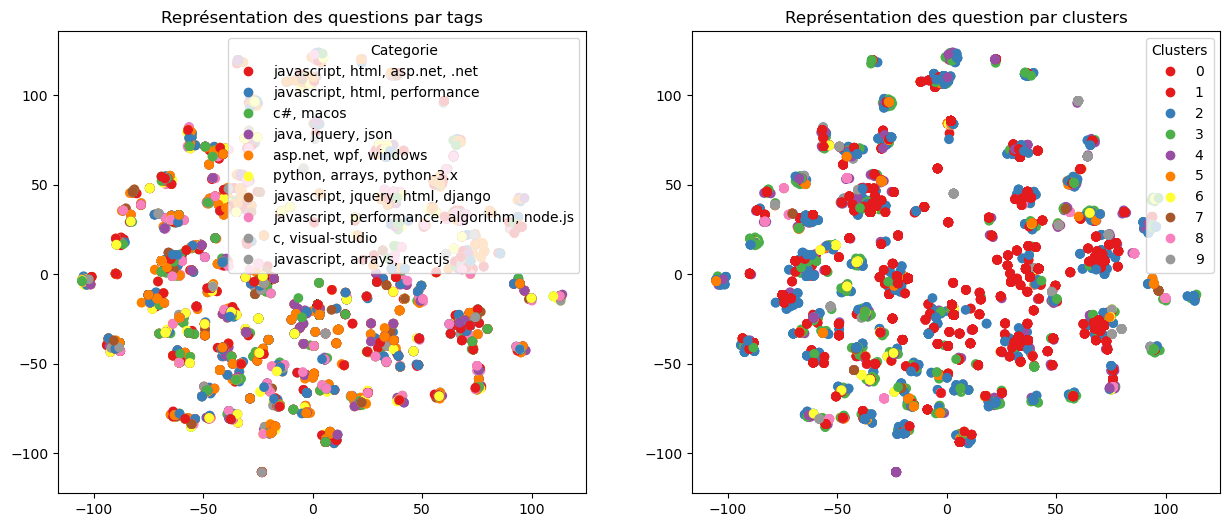

In [126]:
TSNE_visu_fct(X_tsne, y_cat_num, labels)

## best modèle avec  Universal Sentence Encoder (USE)


In [31]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os
# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [32]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.0
2.10.0
Num GPUs Available:  0
False


In [45]:
import tensorflow_hub as hub
import tensorflow_text
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [47]:
import time
def feature_USE_fct(sentences, b_size=10) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [117]:
batch_size = 10
sentences = df['sentence_dl'].to_list()

In [48]:
%%time
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(df.sentence_dl, y_binarized, test_size=0.2, random_state=42)
#
use_train_feat = feature_USE_fct(X_train,batch_size)
use_test_feat = feature_USE_fct(X_test,batch_size)

CPU times: total: 6min 6s
Wall time: 1min 51s


In [53]:
use_test_feat.shape

(8760, 512)

In [55]:
y_test.shape[0]

8761

In [57]:
y_test=y_test[:-1, :]

In [49]:
%%time
clf_lr_use = OneVsRestClassifier(LogisticRegression(
                                            C= 10, penalty= 'l1', solver= 'saga',  
                                          
                                          random_state = 9
                                         ))
clf_lr_use.fit(list(use_train_feat), y_train)
lr_pred_use = clf_lr_use.predict(list(use_test_feat))

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Twins\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


CPU times: total: 23min 38s
Wall time: 23min 43s


In [51]:
lr_pred_use.shape

(8760, 50)

In [52]:
y_test.shape

(8761, 50)

In [58]:
df_metrics_compare = metrics_score("logitR_USE", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=lr_pred_use)
df_metrics_compare

,logitR_BERT,logitR_USE
Accuracy,0.327824,0.316210
F1,0.670116,0.652936
Jaccard,0.496880,0.475392
Recall,0.587398,0.566866
Precision,0.733199,0.717987


## Best modèle avec ACP 

In [59]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=0.8)
pca = pca.fit(Bertfet_train)

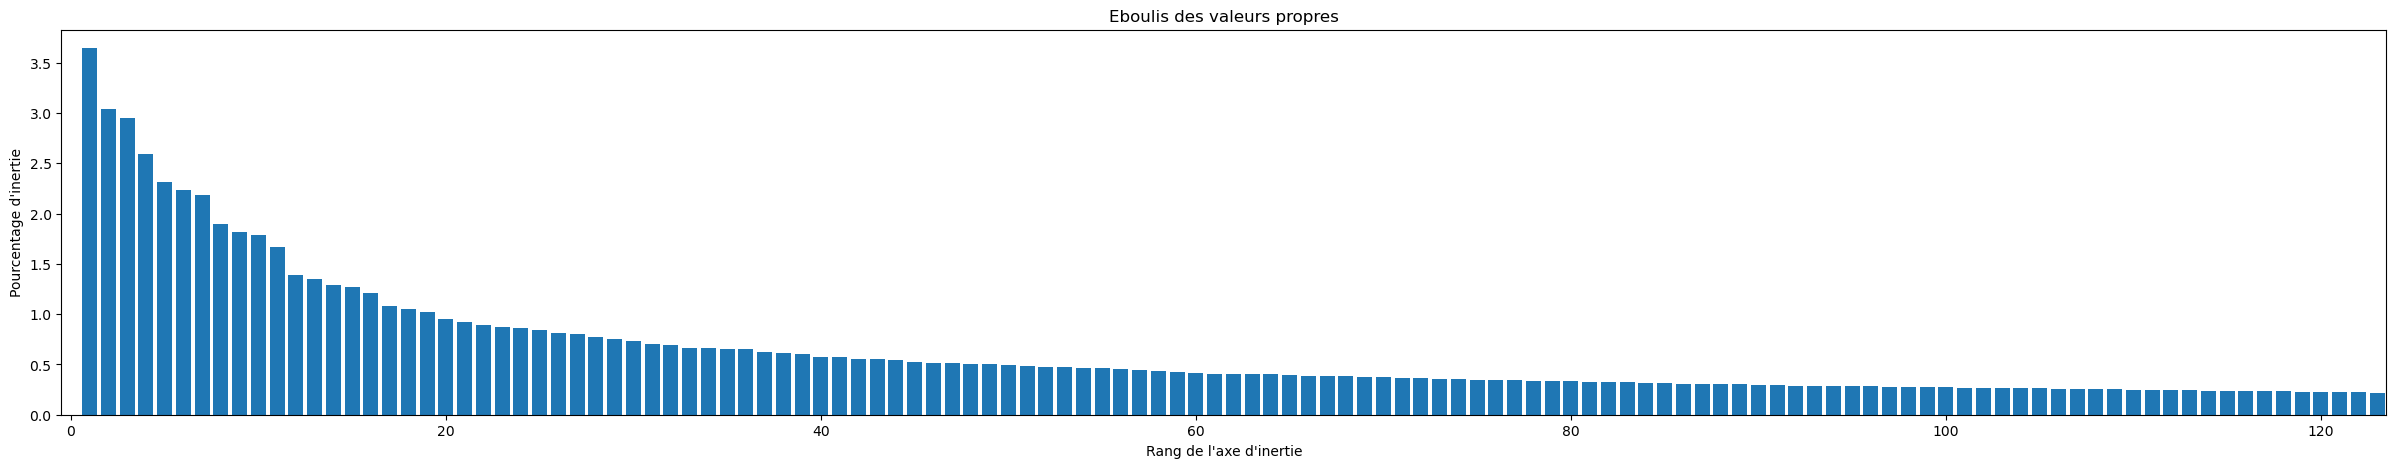

In [62]:
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.figure(figsize=(30, 5))
plt.bar(np.arange(len(scree))+1, scree)
plt.xlabel("Rang de l'axe d'inertie")
plt.xlim(-0.5, len(scree)+0.5)
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig('eboulis_tfidf_pca.png', bbox_inches='tight')
plt.show(block=False)


In [65]:
n_pca_tfidf = len(scree[scree > 0.5])
print("{} composantes principales sont sélectionnées pour nos modèles".format(n_pca_tfidf))

48 composantes principales sont sélectionnées pour nos modèles


In [93]:
Bertfet_train, Bertfet_test, y_train, y_test = train_test_split(sentence_embeddings, y_binarized, test_size=0.25)

In [94]:
pca = PCA(n_components=n_pca_tfidf)
X_train_tfidf_pca = pca.fit_transform(Bertfet_train)
print('La matrice TF-IDF après application d\'une ACP du jeu d\'entrainement représente {} documents par {} composantes principales'.format(
    X_train_tfidf_pca.shape[0], X_train_tfidf_pca.shape[1]))
X_test_tfidf_pca = pca.transform(Bertfet_test)
print('La matrice TF-IDF après application d\'une ACP du jeu de test représente {} documents par {} composantes principales'.format(
    X_test_tfidf_pca.shape[0], X_test_tfidf_pca.shape[1]))

La matrice TF-IDF après application d'une ACP du jeu d'entrainement représente 32850 documents par 48 composantes principales
La matrice TF-IDF après application d'une ACP du jeu de test représente 10951 documents par 48 composantes principales


In [68]:
def plot_tsne(X_train, n_plot_docs=5000):
    tsne = manifold.TSNE(n_components=2, perplexity=30, random_state=0)
    X_tsne = tsne.fit_transform(X_train)

    fig = plt.figure(figsize=(15, 10))
    plt.scatter(X_tsne[:n_plot_docs, 0], X_tsne[:n_plot_docs, 1],
                color=colors_scatter[:n_plot_docs])
    patches = [mpatches.Patch(color=color_from_tag(i), label=i)
               for i in tags_list]
    plt.legend(handles=patches, loc='upper center',
               ncol=7, bbox_to_anchor=(0.5, -0.05))
    plt.title("Projection TSNE d'une représentation ")

In [73]:
list_tags = [
    'c#',
    'java',
    'javascript','python',
    'c++',
 '.net',
 'ios',
 'android',
 'html',
 'php',
 'objective-c',
 'jquery',
 'c',
 'iphone',
 'sql',
 'asp.net',
 'node.js',
 'linux',
 'css',
 'performance',
 'swift',
 'spring',
 'windows',
 'ruby-on-rails',
 'xcode',
 'mysql',
 'sql-server',
 'json',
 'multithreading',
  'unit-testing',
 'asp.net-mvc',
 'arrays',
 'ruby',
 'database',
 'reactjs',
 'django',
 'wpf',
 'macos',
 'string',
 'visual-studio',
 'c++11',
 'algorithm',
 'python-3.x',
 'typescript',
 'xml',
 'gcc',
 'ajax',
 'angular',
 'image',
 'r'
]

In [95]:
reg_logit_clf_pca = OneVsRestClassifier(LogisticRegression(C= 10, penalty= 'l1', solver= 'saga', random_state = 9))
reg_logit_clf_pca.fit(X_train_tfidf_pca, y_train)


OneVsRestClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                 random_state=9,
                                                 solver='saga'))

In [97]:
#Prediction
bert_pred_lr_PCA = reg_logit_clf_pca.predict(X_test_tfidf_pca)

In [98]:
df_metrics_compare = metrics_score("logitR_BERT_ACP", df=df_metrics_compare,
                                   y_true=y_test,
                                   y_pred=bert_pred_lr_PCA)
df_metrics_compare

,logitR_BERT,logitR_USE,logitR_BERT_ACP
Accuracy,0.327824,0.316210,0.294494
F1,0.670116,0.652936,0.646140
Jaccard,0.496880,0.475392,0.453536
Recall,0.587398,0.566866,0.530658
Precision,0.733199,0.717987,0.718362


# selection du modèle et sauvegarde

le modèle choisis : logistic regression + sentence BERT transformer .

In [82]:
final_model = reg_logit_clf # using sentence_transformer - logisticRegression

In [83]:
# Export fitted model and Preprocessor
from pickle import dump

#Modèle serialisation
dump(final_model, open("final_model.pkl","wb"))

In [100]:
dump(multilabel_binarizer, open("multilabel_binarizer.pkl","wb"))